# Clustering examples

Several clustering techniques are applied to see how they work.   
It is a simple example to ilustrate the usage of clustering analysis and how to use some of the implemented methods.   

You can find the data in gapminder website: https://www.gapminder.org/data/. It contains the information for each country about the Corruption Perception Index. Which is a measure of how corrupted is the country. Higher values correspond with less corruption.

- Kmeans
- Hierarchical 
- DBSCAN


## Data Cleaning

In this part we show how the data is and analyze if there are any NAs values, after make decisions of what to do with the missing values.  

First, load the file 'corruption_perception_index_cpi.csv' into a dataframe and then show the columns 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

#load data
df = pd.read_csv('data/corruption_perception_index_cpi.csv')
df.head()
#The columns are the country and the value for the index for each year. 
print(df.columns)

Index(['country', '2012', '2013', '2014', '2015', '2016', '2017'], dtype='object')


Check if the dataframe contains NAs values 

In [6]:
#Check NAs values
print(df.isnull().sum())
print(df.shape)

country     0
2012        5
2013        4
2014        6
2015       12
2016        4
2017        0
dtype: int64
(177, 7)


There are some years that have missing information. As the missing values are not too much. We can fill them with the mean for each column. Fill the values using fillna function.

In [9]:
for col in df.columns[1:]:
    df[col].fillna(df[col].mean(), inplace=True)
print(df.isnull().sum())

country    0
2012       0
2013       0
2014       0
2015       0
2016       0
2017       0
dtype: int64


## K means

  

**Observation**   
Kmeans can return different clusters because it is based on randomness. Therefore, we set a seeed by random_state variable when creating the model.

* Create a function elbow_test that performs a test to check the optimal amount of clusters that should be used. Then call this function.
* Identify the predictors: you need to identify which are the columns to be input for the algorithm. Since it is based on distance, it does not accept the variable 'country'. So, the predictors would be the values other variables.
    The country variable will be used at then end, to know how these countries are grouped by the algorithm. 
    Thus, the variable country is not used to execute the model. 
* Once defined the input for the model, it is necessary to calculate the number of clusters by calling the function elbow test.

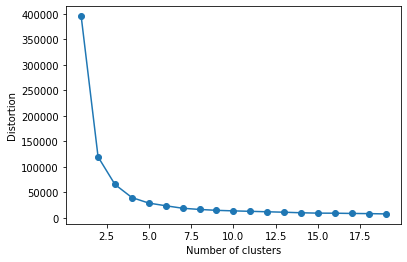

4


In [12]:
import numpy as np
from sklearn.cluster import KMeans
from kneed import KneeLocator

def elbow_test(df, n_init, max_clusters, max_iter):
    distortions = []
    for i in range(1, max_clusters):
        km = KMeans(
            n_clusters=i, init='random',
            n_init=n_init, max_iter=max_iter,
            tol=1e-04, random_state=0
        )
        km.fit(df)
        distortions.append(km.inertia_)

    plt.plot(range(1, max_clusters), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()
    
    kn = KneeLocator(
        range(1, max_clusters),
        distortions,
        curve='convex',
        direction='decreasing',
        interp_method='interp1d',
    )
    return kn.knee
predictors = df[df.columns[1:]]
n_clusters = elbow_test(predictors, 10, 20, 300)
print(n_clusters)

We can see from the graph that the gap point is at 4. It happen when there is not much difference on the distortion. So, we are ready to create the model and execute it. Once the assignation of the clusters is done, we add a new column to the dataset that makes referene to the cluster assigned.  
  
The labels assigned to each value can be found by executing km.labels_.

In [15]:
km = KMeans(n_clusters=n_clusters, random_state=0)
y = km.fit_predict(predictors)
#add column that determines the cluster assigned 
df['cluster'] = km.labels_

### Visualize clusters
Finally, we can plot the clusters and make some conclusions.
We can do this by merging the dataset with the geopandas datasets which contains the geometry. 

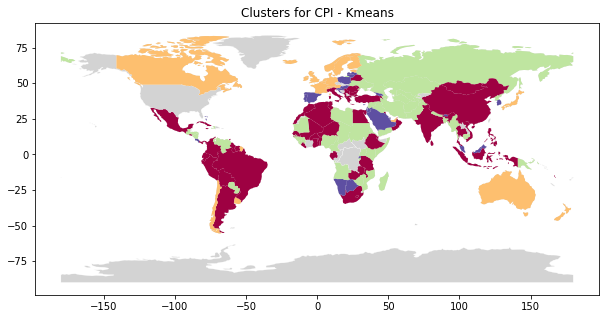

In [18]:
import geopandas
from matplotlib import cm
def plot_clusters(df, title, column_name):
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    merged_inner = pd.merge(left=world, right=df, left_on='name',right_on='country', how='inner')
    cmap = cm.get_cmap('Spectral')
    ax = world.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
    ax.set_title(title)
    merged_inner.plot(column=column_name, ax=ax, cmap=cmap)
plot_clusters(df, 'Clusters for CPI - Kmeans', 'cluster')
df.drop(axis=1, columns='cluster', inplace=True)

From the graph, we can see as we expect that most of South America countries have low CPI, which means that are corrupt. 
You can see that this example is very simple, and tells you obvious things, but image what we can conclude if we combine this information with other variables. We ca see this by plotting for one of the years the clusters

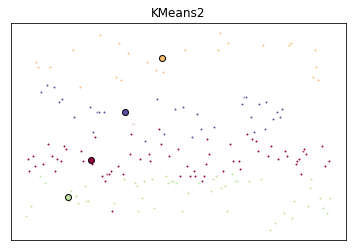

In [21]:
fig = plt.figure(figsize=(6, 4))
colors2 = plt.cm.Spectral(np.linspace(0, 1, len(set(km.labels_))))
ax = fig.add_subplot(1, 1, 1)
df2 = df.copy()
df2['label'] = km.labels_
for k, col in zip(range(len(km.cluster_centers_)), colors2):
    cluster_center = km.cluster_centers_[k]
    ax.plot(df2[df2['label']==k]['2017'], 'w', markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)

ax.set_title('KMeans2')
ax.set_xticks(())
ax.set_yticks(())
plt.show()

## Hierarchical Clustering
For hierarchical clustering we provide an example for Agglomerative Clustering. 
Firstly, drow a dendogram, where the data are represented by the leaves of a tree. 

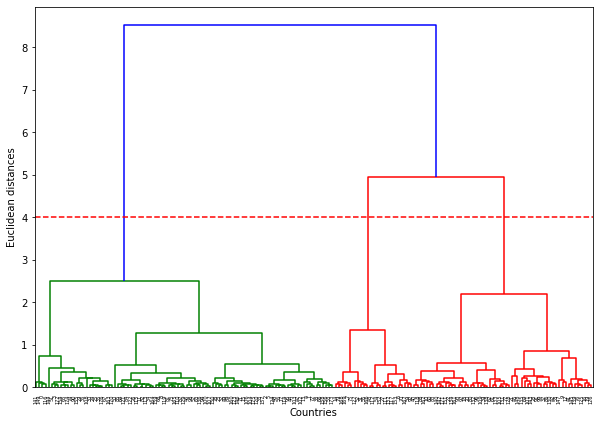

In [24]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
X = df[df.columns[1:]]
#try with ward method, it tries to minimize the variance within each cluster
#you can try after with singe, complete and average 
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_normalized = min_max_scaler.fit_transform(X)
l = linkage(X_normalized, 'ward')
plt.figure(figsize=(10, 7))    
plt.xlabel('Countries')
plt.ylabel('Euclidean distances')
dend = dendrogram(l)
plt.axhline(y=4, color='r', linestyle='--')
plt.show()

### Execute the model and visualize clusters
As we did before, visualize graphically the clusters generated by this method. You can use the function already created. 


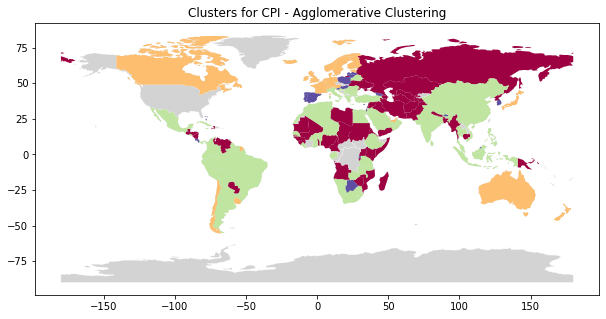

In [27]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
y = cluster.fit_predict(X)
df['cluster'] = cluster.labels_
plot_clusters(df, 'Clusters for CPI - Agglomerative Clustering', 'cluster')
df.drop(axis=1, columns='cluster', inplace=True)

We see in the graph that the clusters are similar distributed as K-means. Different colours were assigned because the label of the cluster is different, but if you compare the graph, the countries included in each cluster are the same.
From the dendrogram we can see that if we take as threshold the dropout point defined by the elbow test and draw a horizontal line through it, it cuts 4 vertical lines. Therefore, 4 is the optimal number of clusters in this case.

## DBSCAN
Use DBSCAN from sklearn library to find the clusters. 

Number of clusters:  7


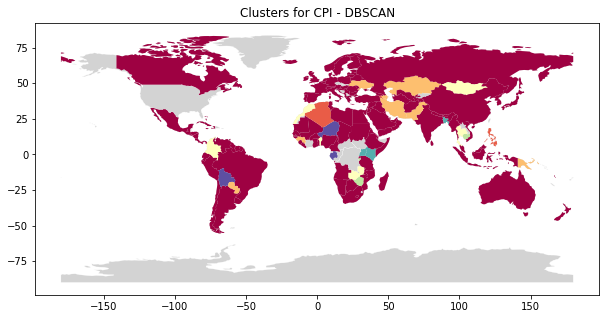

In [30]:
from sklearn.cluster import DBSCAN
import numpy as np
y = DBSCAN(eps=3, min_samples=3).fit(X)
print('Number of clusters: ', len(np.unique(y.labels_)))
df['cluster'] = y.labels_
plot_clusters(df, 'Clusters for CPI - DBSCAN', 'cluster')
df.drop(axis=1, columns='cluster', inplace=True)

The result in this case is difficult to interpret, because we know that the value for the CPI for USA
and the countries in Latin America are far away from each other, but in this case are grouped together.